# **1. IMPORT LIBRARIES**

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

# **2. LOAD FASHION MNIST DATASET**

In [16]:
def load_fashion_mnist():
    (x_train, _), (x_test, _) = fashion_mnist.load_data()
    return x_train, x_test

x_train, x_test = load_fashion_mnist()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **3. PREPROCESS IMAGES**

In [17]:
def preprocess_images(x_train, x_test):
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, -1)  # Shape: (28, 28, 1)
    x_test = np.expand_dims(x_test, -1)
    return x_train, x_test

x_train, x_test = preprocess_images(x_train, x_test)

# **4. ADD NOISE TO IMAGES**

In [18]:
def add_noise(x_train, x_test, noise_factor=0.5):
    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)  # Keep values between 0 and 1
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    return x_train_noisy, x_test_noisy

x_train_noisy, x_test_noisy = add_noise(x_train, x_test)

# **5. BUILD AUTOENCODER**

In [19]:
def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Compile Autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

autoencoder = build_autoencoder()

# **6. TRAIN THE AUTOENCODER**

In [20]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    verbose=1
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.3856 - val_loss: 0.3128
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3072 - val_loss: 0.3054
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3023 - val_loss: 0.3022
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2998 - val_loss: 0.3004
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2974 - val_loss: 0.2991
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2965 - val_loss: 0.2978
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2948 - val_loss: 0.2968
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2939 - val_loss: 0.2968
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2936 - val_loss: 0.2954
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2925 - val_loss: 0.2947


# **7. DENOISE TEST IMAGES**

In [21]:
decoded_imgs = autoencoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# **8. VISUALIZE NOISY VS DENOISED IMAGES**

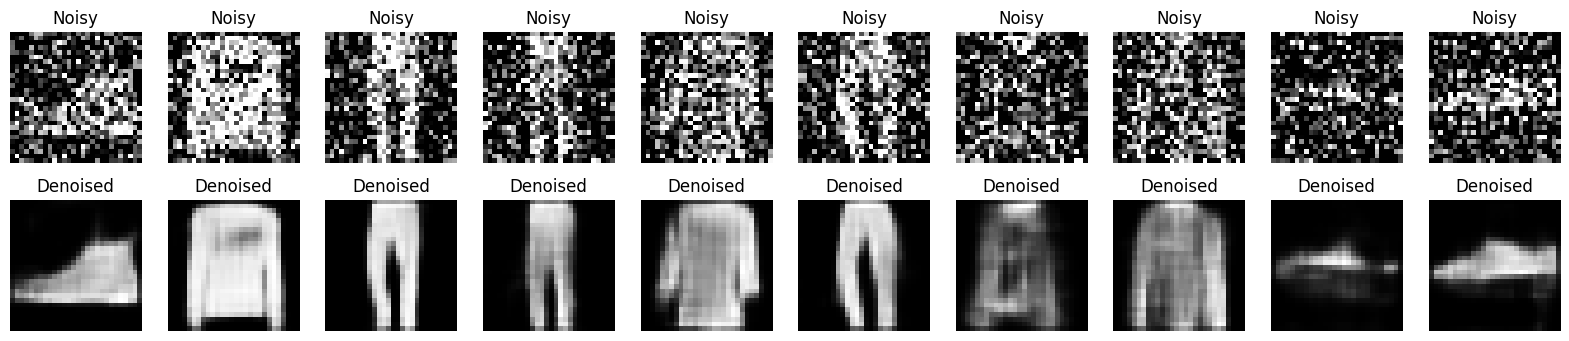

In [22]:
def visualize_results(x_test_noisy, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Noisy images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')
    plt.show()

visualize_results(x_test_noisy, decoded_imgs)

# **9. EVALUATE THE MODEL**

In [23]:
def evaluate_model(autoencoder, x_test_noisy, x_test, threshold=0.1):
    loss = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
    print(f"Test Loss: {loss}")

    # Accuracy Calculation
    diff = np.abs(autoencoder.predict(x_test_noisy) - x_test)
    correct_predictions = np.sum(diff < threshold)
    accuracy = correct_predictions / (x_test.shape[0] * x_test.shape[1] * x_test.shape[2])
    print(f"Accuracy based on threshold: {accuracy}")

evaluate_model(autoencoder, x_test_noisy, x_test)

Test Loss: 0.29471373558044434
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy based on threshold: 0.7587399234693878
